## Alzheimer's Disease Progression prediction

1. **Environment Setup**:
   - Install Python and PyTorch with GPU support (CUDA).
   - Install additional libraries: `torchvision` for model architectures and common datasets, `numpy` for numerical operations, `matplotlib` and `pandas` for data visualization, `scikit-learn` for additional machine learning tools.

2. **Data Preprocessing**:
   - **Data Loading**: Utilize PyTorch's `torchvision.datasets.ImageFolder` or a custom `Dataset` class to load the .jpg MRI files.
   - **Data Splitting**: Split the data into training, validation, and test sets, ensuring stratified sampling for class balance.
   - **Data Transformation**:
     - Resize images to the required input size for each model.
     - Apply normalization using means and standard deviations compatible with the pre-trained networks.
     - Implement data augmentation (e.g., rotations, flips) to improve model generalization.

3. **Exploratory Data Analysis (EDA)**:
   - Visualize sample images from each class.
   - Analyze class distribution, identifying any imbalance.
   - Explore image characteristics like contrast, brightness, and specific features relevant to Alzheimer's.

4. **Model Setup and Adaptation**:
   - **ResNet, VGGNet, DenseNet, MobileNet**:
     - Load each model with pre-trained weights.
     - Modify the final layer(s) to output four classes (demented, very mild demented, etc.).
   - **U-Net**:
     - Consider using U-Net for image segmentation tasks.
     - Adapt U-Net for outputting segmented regions of interest in the brain images.

5. **Loss Function and Optimizer**:
   - Utilize Cross-Entropy Loss for classification tasks.
   - Choose an optimizer like Adam or SGD with a consistent learning rate and other hyperparameters for all models.

6. **Training and Validation**:
   - Train each model on the training set while monitoring performance on the validation set.
   - Implement callbacks for early stopping based on validation loss and for saving the best model checkpoints.

7. **Performance Evaluation**:
   - Evaluate each model on the test dataset.
   - Use metrics such as accuracy, precision, recall, F1-score, and area under the ROC curve for comparison.

8. **Hyperparameter Tuning and Fine-Tuning**:
   - Experiment with different learning rates, batch sizes, and other hyperparameters.
   - Fine-tune the models by unfreezing some of the top layers and retraining with a lower learning rate.

9. **Model Interpretation and Analysis**:
   - Apply techniques like Grad-CAM to visualize model attention on MRI images.
   - Analyze false positives and false negatives to understand model weaknesses.

10. **Deployment** (optional):
   - Prepare the best-performing model for deployment.
   - Convert the model to a format suitable for the chosen deployment platform.

11. **Documentation and Reporting**:
   - Thoroughly document the methodology, code, and results.
   - Prepare a comprehensive report or presentation detailing the findings and model comparisons.

### Additional Substeps:
- **Statistical Analysis**: Conduct statistical tests to assess the significance of performance differences between models.
- **Collaboration with Medical Experts**: Regularly consult with medical professionals to validate findings and gain clinical insights.
- **Continuous Monitoring and Updating**: Plan for ongoing monitoring of model performance and periodic updates based on new data or research findings.

This detailed plan provides a structured approach to comparing different pre-trained models on MRI images for predicting Alzheimer's disease progression, ensuring thorough exploration and evaluation at each step.

In [1]:
# Import Necessary Packages for Image Processing and Data Loading
import os
import torch
import logging
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import torchvision.models as models

- The `torch.cuda.is_available()` function checks if there is a GPU available that PyTorch can use. If a GPU is available and PyTorch can use it, the string 'cuda' is returned, otherwise 'cpu' is returned. The 'cuda' or 'cpu' string is then passed to `torch.device()` to create a device object.

- The `torch.device('cuda')` means that the GPU will be used for computation if it's available. If not, `torch.device('cpu')` means that the CPU will be used for computation. Using a GPU for computation can significantly speed up your code if you're performing large-scale matrix operations, which are common in machine learning.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Set up logging
logging.basicConfig(level=logging.INFO)

In [4]:
# Define dataset directory and labels
dataset_path = './Data'
classes = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
print(class_to_idx)

{'Mild Dementia': 0, 'Moderate Dementia': 1, 'Non Demented': 2, 'Very mild Dementia': 3}


### AlzheimerDataset inherits from the PyTorch Dataset class
- The class is typically used in the context of machine learning projects where you need to load and preprocess your data
- The `__init__` method is the initializer that gets called when a new instance of the class is created which takes three parameters: self, root_dir and transform.
    - *Instance variables*:
        - `self` parameter is a reference to the current instance of the class
        - `root_dir` is a string representing the root directory where the image data is stored
        - `transform` is an optional parameter that could be used to apply any transformations to the images, such as resizing, normalization, or data augmentation techniques
        - `self.images` and `self.labels` are used to store the paths of the image files and their corresponding labels respectively
    - The for loop iterates over a list of class names constructing a path to the directory containing images of that class by joining the root directory and the class name.
    - Then, iterates over all the files in that directory appending the full path of the image file to the `self.images` list and its corresponding class index to the `self.labels` list.
    - The class index is obtained from a dictionary `class_to_idx` using the class name as the key
- The `__len__` method returns the number of images in the dataset, which is the length of the `self.images` list
- The `__getitem__` method is used to retrieve the image and its corresponding label at a given index. It opens the image file, converts it to RGB, and applies the transformations if any are defined. It then returns a tuple of the transformed image and its label.

> In summary, this class is used to create a dataset object that holds the paths to all images and their corresponding labels. The images are organized in directories by class. This structure is common in many machine learning projects.

In [5]:
class AlzheimerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for cls_name in classes:
            cls_path = os.path.join(root_dir, cls_name)
            assert os.path.isdir(cls_path), f"Directory {cls_path} does not exist"
            for img_name in os.listdir(cls_path):
                self.images.append(os.path.join(cls_path, img_name))
                self.labels.append(class_to_idx[cls_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except IOError:
            logging.error(f"Error opening image: {img_path}")
            return None, None

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

### Transformation pipeleine definition
- `transforms` module from the PyTorch library defines a series of transformations that will be applied to images
- `Compose` function is used to chain together multiple transformations:
    - `transformations.Resize((224,224))`: Resizes images to 224x224 pixels since ML models require their input to be of consistent size
    - `transforms.toTensor()`: Converts image loaded as PIL (Python Imaging Library) image, into a PyTorch tensor.
    - `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: 
        - Normalizes tensor image, where the mean and standard deviation values are specified for each RGB color channel
        - Normalization helps to standardize the input to a model and the values used here are the standard normalization parameters for pre-trained models provided by PyTorch

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust based on model input
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Create Dataset and Validate
try:
    alzheimer_dataset = AlzheimerDataset(dataset_path, transform=transform)
    assert len(alzheimer_dataset) > 0, "Dataset is empty"
except Exception as e:
    logging.error(f"Failed to create dataset: {e}")
    raise

In [8]:
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
import seaborn as sns
import pandas as pd

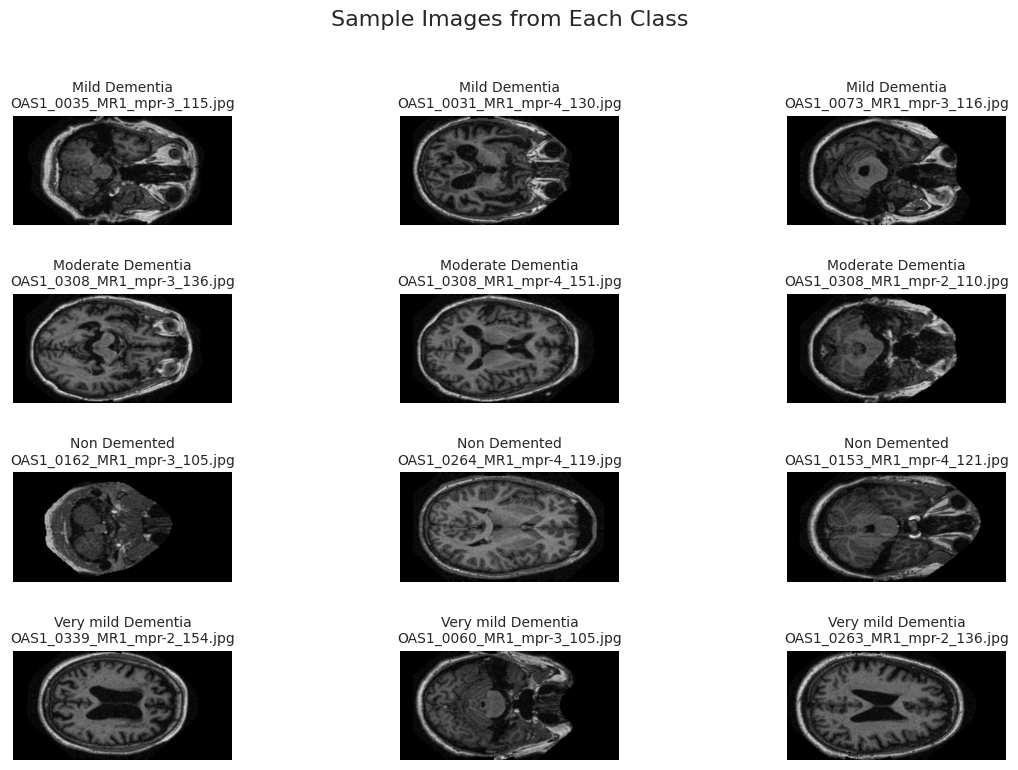

In [9]:
def visualize_sample_images_seaborn(dataset, num_samples=3):
    sns.set(style="white")
    fig, axs = plt.subplots(nrows=len(classes), ncols=num_samples, figsize=(12, 8))
    fig.suptitle('Sample Images from Each Class', fontsize=16)

    for i, cls_name in enumerate(classes):
        cls_path = os.path.join(dataset.root_dir, cls_name)
        images = os.listdir(cls_path)
        sample_images = random.sample(images, num_samples)
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(cls_path, img_name)
            image = Image.open(img_path).convert('RGB')
            axs[i, j].imshow(image)
            axs[i, j].set_title(f"{cls_name}\n{img_name}", fontsize=10)
            axs[i, j].axis('off')

    plt.tight_layout(pad=2.0)
    plt.show()

# Replace 'alzheimer_dataset' with your actual dataset variable
visualize_sample_images_seaborn(alzheimer_dataset)


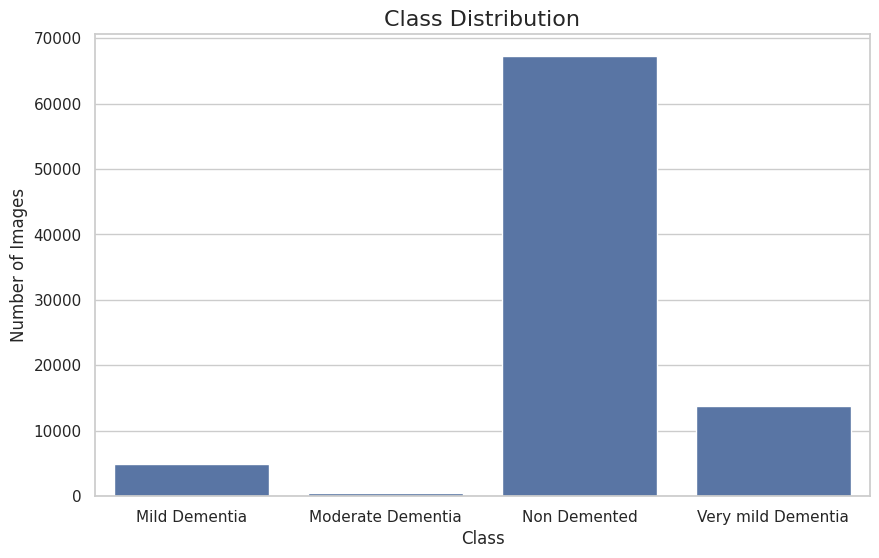

In [10]:
class_counts = {cls_name: len(os.listdir(os.path.join(dataset_path, cls_name))) for cls_name in classes}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# To address the deprecation, we're removing the 'palette' parameter
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.show()

In [11]:
def calculate_image_metrics(image):
    # Convert to grayscale for contrast calculation
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    contrast = gray_image.std()
    brightness = gray_image.mean()
    return contrast, brightness

# Assuming 'alzheimer_dataset' has been initialized and has 'images' attribute
contrast_values, brightness_values = [], []
for img_path in alzheimer_dataset.images[:100]:  # Limiting the number for quick analysis
    image = Image.open(img_path).convert('RGB')
    contrast, brightness = calculate_image_metrics(image)
    contrast_values.append(contrast)
    brightness_values.append(brightness)


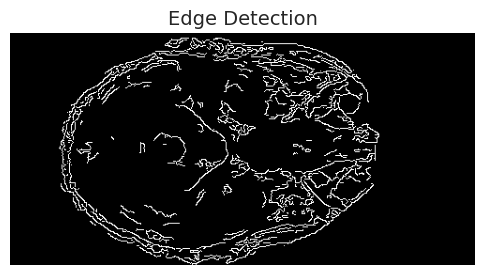

In [12]:
def edge_detection(image):
    edges = cv2.Canny(np.array(image), 100, 200)
    return edges

# Assuming 'edge_detection' function and 'sample_image' are defined as per your existing code
sample_image = Image.open(alzheimer_dataset.images[0]).convert('RGB')
edges = edge_detection(sample_image)
plt.figure(figsize=(6, 4))
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection', fontsize=14)
plt.axis('off')
plt.show()


/home/rikato/Code+Notes/Prometeo/prometeo-venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rikato/Code+Notes/Prometeo/prometeo-venv/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/rikato/Code+Notes/Prometeo/prometeo-venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rikato/Code+Notes/Prometeo/prometeo-ven

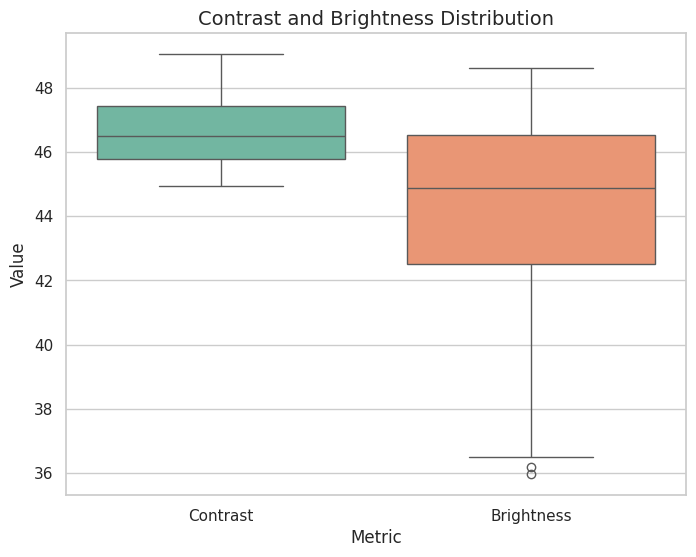

In [13]:
data = pd.DataFrame({
    'Contrast': contrast_values,
    'Brightness': brightness_values
})

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Reshaping the DataFrame for seaborn boxplot
data_melted = data.melt(var_name='Metric', value_name='Value')

# To address the deprecation warning, we're modifying the use of 'palette'
sns.boxplot(x='Metric', y='Value', data=data_melted, hue='Metric', palette="Set2", dodge=False)

plt.title('Contrast and Brightness Distribution', fontsize=14)
plt.legend(title='', frameon=False)
plt.show()

In [14]:
# Data Splitting (Example: 70% train, 15% validation, 15% test)
train_size = int(0.7 * len(alzheimer_dataset))
val_size = int(0.15 * len(alzheimer_dataset))
test_size = len(alzheimer_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(alzheimer_dataset, [train_size, val_size, test_size])


### Data loaders creation
- The `DataLoader` class takes two required arguments: a dataset and a batch size
- The dataset is expected to be an instance of a class that implements the `__getitem__` and `__len__` methods, such as a `Dataset` object or a custom dataset class
- The batch size is an integer that specifies the number of samples per batch
#### Code explained -
- The `train_loader`, `val_loader` and `test_loader` are created with `train_dataset`, `val_dataset` and `test_dataset` along with a batch of size 32 respectively
- The `shuffle` parameter is set to `True`, which means that the data will be shuffled at every epoch

In [15]:
# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

- The models being loaded are ResNet50, VGG16, DenseNet121, and MobileNetV2. These models have been trained on large datasets and can be used as a starting point for your own image classification tasks, a technique known as transfer learning.

- The number of classes in your dataset is specified as `num_classes = 4`. 

- For each model, the code first loads the pre-trained weights. Then, the model itself is loaded with these weights using `models.resnet50(weights=resnet_weights)`.

- The next step is to modify the last layer of each model to match the number of classes in your dataset. This is done because the pre-trained models were originally trained to classify images into a different number of classes (for example, 1000 classes for the models trained on ImageNet). 

- The code replaces the last layer with a new fully connected layer that has the same number of input features as the original layer but a different number of output features, specified by `num_classes`.

- Finally, all the modified models are stored in a dictionary called `models_dict`, with the model names as keys and the models themselves as values. This makes it easy to access and use the models later in your code.

In [16]:
import torch
import torchvision.models as models
from torchvision.models import ResNet50_Weights, VGG16_Weights, DenseNet121_Weights, MobileNet_V2_Weights

# Number of classes in your dataset
num_classes = 4

# Load pre-trained ResNet
resnet_weights = ResNet50_Weights.DEFAULT
resnet = models.resnet50(weights=resnet_weights)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)

# Load pre-trained VGGNet
vggnet_weights = VGG16_Weights.DEFAULT
vggnet = models.vgg16(weights=vggnet_weights)
vggnet.classifier[6] = torch.nn.Linear(vggnet.classifier[6].in_features, num_classes)

# Load pre-trained DenseNet
densenet_weights = DenseNet121_Weights.DEFAULT
densenet = models.densenet121(weights=densenet_weights)
densenet.classifier = torch.nn.Linear(densenet.classifier.in_features, num_classes)

# Load pre-trained MobileNet
mobilenet_weights = MobileNet_V2_Weights.DEFAULT
mobilenet = models.mobilenet_v2(weights=mobilenet_weights)
mobilenet.classifier[1] = torch.nn.Linear(mobilenet.classifier[1].in_features, num_classes)

# A dictionary to hold the models
models_dict = {
    'ResNet': resnet,
    'VGGNet': vggnet,
    'DenseNet': densenet,
    'MobileNet': mobilenet
}

# Checking
for model_name, model in models_dict.items():
    # Print the modified model
    print(f"Modified {model_name}:")
    print(model)


Modified ResNet:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [17]:
import torch.nn as nn

# Loss Function
criterion = nn.CrossEntropyLoss()


In [18]:
import torch.optim as optim

# Adam optimizer
learning_rate = 0.001
optimizer_resnet = optim.Adam(resnet.parameters(), lr=learning_rate)
optimizer_vggnet = optim.Adam(vggnet.parameters(), lr=learning_rate)
optimizer_densenet = optim.Adam(densenet.parameters(), lr=learning_rate)
optimizer_mobilenet = optim.Adam(mobilenet.parameters(), lr=learning_rate)


In [19]:
# Early stopping and model checkpoint
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, optimizer, model_name):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, model_name)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, model_name)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer, model_name):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()},
                    f'{model_name}_checkpoint.pt')

        self.val_loss_min = val_loss


In [20]:
# Training and validation function
def train_and_validate(model, optimizer, scheduler, num_epochs=25):
    model.to(device)
    early_stopping = EarlyStopping(patience=7, verbose=True)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():  # Mixed precision context
                outputs = model(inputs)

            outputs = outputs.float()  # Convert outputs to full precision before loss calculation
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs} Train loss: {train_loss:.4f} Val loss: {val_loss:.4f}')

        # Reduce learning rate on plateau and early stopping
        scheduler.step(val_loss)
        early_stopping(val_loss, model, optimizer, model.__class__.__name__)

        if early_stopping.early_stop:
            print("Early stopping")
            break
        torch.cuda.empty_cache()  # Clear CUDA cache

In [21]:
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from torch.cuda.amp import GradScaler, autocast

In [22]:
# Optimizers
optimizers = {
    'ResNet': optim.Adam(models_dict['ResNet'].parameters(), lr=0.001),
    'VGGNet': optim.Adam(models_dict['VGGNet'].parameters(), lr=0.001),
    'DenseNet': optim.Adam(models_dict['DenseNet'].parameters(), lr=0.001),
    'MobileNet': optim.Adam(models_dict['MobileNet'].parameters(), lr=0.001)
}

In [23]:
# Learning Rate Scheduler
schedulers = {
    model_name: ReduceLROnPlateau(optimizers[model_name], patience=3, verbose=True)
    for model_name in models_dict.keys()
}

# Number of epochs for training
num_epochs = 1

# Training and validating each model
for model_name, model in models_dict.items():
    print(f"\nTraining and validating {model_name}...\n")
    optimizer = optimizers[model_name]
    scheduler = schedulers[model_name]
    train_and_validate(model, optimizer, scheduler, num_epochs=num_epochs)

    # After training, load the best model checkpoint if needed
    checkpoint_filename = f'{model_name}_checkpoint.pt'
    if model_name == 'VGGNet':
        checkpoint_filename = 'VGG_checkpoint.pt'
    elif model_name == 'MobileNet':
        checkpoint_filename = 'MobileNetV2_checkpoint.pt'
    
    checkpoint = torch.load(checkpoint_filename, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    torch.cuda.empty_cache()  # Clear CUDA cache


Training and validating ResNet...

Epoch 1/1 Train loss: 0.2526 Val loss: 0.0908
Validation loss decreased (inf --> 0.090818). Saving model ...

Training and validating VGGNet...

Epoch 1/1 Train loss: 0.6971 Val loss: 0.6752
Validation loss decreased (inf --> 0.675236). Saving model ...

Training and validating DenseNet...

Epoch 1/1 Train loss: 0.3664 Val loss: 0.2282
Validation loss decreased (inf --> 0.228216). Saving model ...

Training and validating MobileNet...

Epoch 1/1 Train loss: 0.2612 Val loss: 0.0795
Validation loss decreased (inf --> 0.079507). Saving model ...


In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

In [37]:
# Function to evaluate model performance
def evaluate_performance(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to binary format for multiclass ROC AUC calculation
    all_labels_binary = label_binarize(all_labels, classes=[0, 1, 2, 3])
    all_preds_binary = label_binarize(all_preds, classes=[0, 1, 2, 3])

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    roc_auc = roc_auc_score(all_labels_binary, all_preds_binary, average='macro', multi_class='ovr')

    return accuracy, precision, recall, f1, roc_auc

In [39]:
# Evaluate each model
for model_name, model in models_dict.items():
    print(f"\nEvaluating {model_name}...\n")
    accuracy, precision, recall, f1, roc_auc = evaluate_performance(model, test_loader, device)
    print(f"Model: {model_name}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-score: {f1}\nROC AUC: {roc_auc}\n")


Evaluating ResNet...

Model: ResNet
Accuracy: 0.965527878460708
Precision: 0.963639961524553
Recall: 0.8890428877358827
F1-score: 0.9234647790498813
ROC AUC: 0.9299313668064725


Evaluating VGGNet...

Model: VGGNet
Accuracy: 0.7750443433330763
Precision: 0.19376108583326906
Recall: 0.25
F1-score: 0.21831689620715122
ROC AUC: 0.5


Evaluating DenseNet...



/home/rikato/Code+Notes/Prometeo/prometeo-venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: DenseNet
Accuracy: 0.9083056990822858
Precision: 0.8259072457754469
Recall: 0.6109755523559536
F1-score: 0.6380565355554406
ROC AUC: 0.770765915579313


Evaluating MobileNet...

Model: MobileNet
Accuracy: 0.972237217552248
Precision: 0.9239353209949943
Recall: 0.962615202744625
F1-score: 0.9406950770988338
ROC AUC: 0.9744238867936967



In [85]:
# import torch
# from torchvision import models, transforms
# from PIL import Image

# # Function to predict using MobileNetV2 and a list of image paths
# def predict_with_mobilenetv2(image_paths):
#     # Load the state dict into the model
#     model = models.mobilenet_v2(weights=None)
#     state_dict = torch.load('./models/MobileNetV2_checkpoint.pt')  # Adjust path as needed
#     model.load_state_dict(state_dict)
#     model.eval()  # Set the model to evaluation mode

#     # Transform for the images
#     transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Adjust based on model input
#     transforms.Grayscale(num_output_channels=3),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])


#     # Predict each image
#     predictions = []
#     for image_path in image_paths:
#         image = Image.open(image_path)
#         image_tensor = transform(image).unsqueeze(0)

#         with torch.no_grad():
#             outputs = model(image_tensor)
#             _, predicted = torch.max(outputs, 1)
#             predictions.append(predicted.item())

#     return predictions

# # List of image paths to predict
# image_paths = [
#     './Data/Mild Dementia/OAS1_0028_MR1_mpr-1_100.jpg',
#     './Data/Mild Dementia/OAS1_0028_MR1_mpr-1_101.jpg',
#     './Data/Mild Dementia/OAS1_0028_MR1_mpr-1_102.jpg',
#     './Data/Mild Dementia/OAS1_0028_MR1_mpr-1_103.jpg',
#     './Data/Moderate Dementia/OAS1_0308_MR1_mpr-1_100.jpg',
#     './Data/Moderate Dementia/OAS1_0308_MR1_mpr-1_101.jpg',
#     './Data/Moderate Dementia/OAS1_0308_MR1_mpr-1_102.jpg',
#     './Data/Moderate Dementia/OAS1_0308_MR1_mpr-1_103.jpg'
#     # Add paths to your 8 images
# ]

# # Make predictions
# predicted_classes = predict_with_mobilenetv2(image_paths)
# for i, pred_class in enumerate(predicted_classes):
#     print(f"Image {i+1} Predicted Class: {pred_class}")


Image 1 Predicted Class: 944
Image 2 Predicted Class: 944
Image 3 Predicted Class: 944
Image 4 Predicted Class: 944
Image 5 Predicted Class: 944
Image 6 Predicted Class: 944
Image 7 Predicted Class: 944
Image 8 Predicted Class: 944


In [61]:
# # Other imports and model loading code...

# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image

# # Function to apply Grad-CAM
# def apply_grad_cam(model, target_layer, input_tensor):
#     cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())
#     # Generate the CAM mask
#     targets = [ClassifierOutputTarget(0)]  # You might want to update this target based on your specific use case
#     grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
#     # Take the first item in the batch
#     grayscale_cam = grayscale_cam[0, :]
#     return grayscale_cam

# # Function to visualize Grad-CAM
# def visualize_grad_cam(model, model_name, target_layer, input_tensor, original_image):
#     # Apply Grad-CAM
#     grayscale_cam = apply_grad_cam(model, target_layer, input_tensor)

#     # Visualize the CAM
#     cam_image = show_cam_on_image(original_image, grayscale_cam, use_rgb=True)

#     # Display the CAM image
#     plt.figure(figsize=(10, 5))
#     plt.imshow(cam_image)
#     plt.title(f"Grad-CAM for {model_name}")
#     plt.show()

# # Load models, set target layers, and call visualize_grad_cam for each model...


In [62]:
# # Load an image from file
# image_path = './Data/Moderate Dementia/OAS1_0308_MR1_mpr-1_122.jpg'  # Update this path to your image file
# original_image = Image.open(image_path)

# # Preprocess the image for the model
# preprocess = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize to the input size of the model
#     transforms.ToTensor(),          # Convert to tensor
#     transforms.Normalize(           # Normalize for the model
#         mean=[0.485, 0.456, 0.406],  # These values might vary depending on the model
#         std=[0.229, 0.224, 0.225]
#     ),
# ])

# test_image_tensor = preprocess(original_image).unsqueeze(0)  # Add batch dimension

# # Convert the original image to NumPy array for visualization
# test_image_original = np.array(original_image)

# # Ensure the image is in the correct format (W x H x C) and normalized between 0 and 1 for visualization
# if test_image_original.ndim == 2:  # If the image is grayscale, convert to RGB
#     test_image_original = np.stack((test_image_original,)*3, axis=-1)
# if test_image_original.shape[2] > 3:  # If the image has an alpha channel, remove it
#     test_image_original = test_image_original[:, :, :3]
# test_image_original = test_image_original / 255.0  # Normalize to [0, 1]


In [63]:
# from torchvision.models import densenet121, mobilenet_v2, resnet50, vgg16
# import torch.nn as nn

# # Modify this number based on the number of classes in your dataset
# num_classes = 4

# models = {
#     'DenseNet': densenet121(),
#     'MobileNetV2': mobilenet_v2(),
#     'ResNet': resnet50(),
#     'VGG': vgg16()
# }

# # Adjust the classifier for DenseNet
# models['DenseNet'].classifier = nn.Linear(models['DenseNet'].classifier.in_features, num_classes)

# # Load each model checkpoint
# model_checkpoints = {
#     'DenseNet': 'DenseNet_checkpoint.pt',
#     'MobileNetV2': 'MobileNetV2_checkpoint.pt',
#     'ResNet': 'ResNet_checkpoint.pt',
#     'VGG': 'VGG_checkpoint.pt'
# }


# for model_name, checkpoint_path in model_checkpoints.items():
#     checkpoint = torch.load(checkpoint_path, map_location='cpu')
#     if 'model_state_dict' in checkpoint:
#         models[model_name].load_state_dict(checkpoint['model_state_dict'])
#     else:
#         models[model_name].load_state_dict(checkpoint)

#     # Define the target layer for each model
#     if model_name == 'DenseNet':
#         target_layer = models[model_name].features.norm5
#     elif model_name == 'MobileNetV2':
#         target_layer = models[model_name].features[-1]
#     elif model_name == 'ResNet':
#         target_layer = models[model_name].layer4[-1]
#     elif model_name == 'VGG':
#         target_layer = models[model_name].features[-1]

#     # Visualize Grad-CAM for each model
#     visualize_grad_cam(models[model_name], model_name, target_layer, test_image_tensor, test_image_original)


NameError: name 'target_layers' is not defined

In [64]:
# # Example code to analyze false positives and negatives
# # Assuming you have a way to extract model predictions and actual labels

# false_positives = []  # List of false positive instances
# false_negatives = []  # List of false negative instances

# # Analyze and visualize these instances
# for instance in false_positives + false_negatives:
#     image, actual_label, predicted_label = instance  # Extract data
#     # Display the image and labels
#     plt.imshow(image)
#     plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
#     plt.show()
#     # Add your analysis or comments on why the model might have failed in this case

In [72]:
# # Assuming 'models' is a dictionary containing your model instances
# model_to_save = models['MobileNetV2']

# # Save the state dictionary of the MobileNetV2 model instance
# torch.save(model_to_save.state_dict(), 'models/MobileNetV2_checkpoint.pt')


In [93]:
import torch
from torchvision import models, transforms
from PIL import Image

# Create an instance of the model
# Updated to use weights=None as per the latest torchvision API
model = models.mobilenet_v2(weights=None)

# Load the state dict into the model
state_dict = torch.load('./models/MobileNetV2_checkpoint.pt')  # Adjust path as needed
model.load_state_dict(state_dict)

model.eval()  # Set the model to evaluation mode

import torch.nn.functional as F

def predict_with_probabilities(image_path):
    # Transform the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)

    # Predict
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        top_prob, top_class = probabilities.topk(1, dim=1)

        # Return the raw tensors for debugging
        return top_class, top_prob

# Test the function
top_class, top_prob = predict_with_probabilities('./Data/Moderate Dementia/OAS1_0308_MR1_mpr-1_101.jpg')
print("Top class tensor:", top_class)
print("Top probability tensor:", top_prob)

Top class tensor: tensor([[0]])
Top probability tensor: tensor([[0.0010]])
